# Redes de deslocamento para acesso ao parto hospitalar no Brasil

## Contexto

No Brasil, 98% dos partos ocorrem em ambiente hospitalar, e 77% no Sistema Único de Saúde (SUS). O acesso oportuno aos serviços obstétricos de internação para o parto é fundamental para garantir a segurança do cuidado materno e neonatal. Entretanto, há “vazios assistenciais” na oferta de serviços hospitalares pelo SUS que fazem com que grande parte das parturientes precise se deslocar de um município a outro para ser assistida.

O retardo na atenção obstétrica no momento do parto está associado à desfechos maternos adversos, e o deslocamento de grandes distâncias tem sido associado a níveis elevados de mortalidade infantil e neonatal, além de maior risco de morbimortalidade materna. Assim, a análise da distância percorrida pelas parturientes de sua residência até o hospital é um indicador útil e sensível para avaliar a dificuldade em acessar cuidados maternos e neonatais no SUS.

A análise da acessibilidade geográfica é um componente importante da avaliação de serviços de saúde e reflete aspectos da distribuição espacial da oferta de serviços que dificultam ou promovem sua utilização. A metodologia de análise de redes sociais (ARS) tem sido utilizada nesse contexto, incluindo a internação para o parto, e também como ferramenta para gestão em saúde.

Este projeto tem o objetivo de analisar a acessibilidade geográfica ao parto hospitalar realizado no SUS nos últimos 10 anos, em todo Brasil, aplicando a ARS como uma nova ferramenta para a gestão de serviços de saúde. Serão utilizados dados do Departamento de Informática do SUS (DATASUS) para a construção das redes de deslocamento das gestantes em busca de internação para o parto, levando-se em conta as distâncias percorridas, mapeando fluxos preferenciais e identificando lacunas geográficas de atendimento e polos de atração de maior demanda, como medida de inequidade no acesso aos serviços. O projeto avança no processo de avaliação do sistema de saúde ao desenvolver novos indicadores de acesso à serviços obstétricos, baseados em uma metodologia inovadora, e com abrangência nacional e aplicabilidade a outras áreas de saúde pública.

Espera-se, com este estudo, gerar evidências que permitam um melhor entendimento da organização e das fragilidades do SUS na assistência à saúde da mulher no ciclo gravídico-puerperal, contribuindo para o planejamento da atenção obstétrica e para o fortalecimento de políticas públicas voltadas para melhoria do acesso aos serviços de saúde.

## Links

- https://github.com/lucaslopes/partos/

- https://pcdas.icict.fiocruz.br/rede-de-parcerias/a-distancia-importa-redes-de-deslocamento-para-acesso-ao-parto-hospitalar-no-brasil/

## Importação das dependências

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import config, data_load, data_info, data_plot
from plotly import graph_objects as go

# Fontes de dados

Utilizamos algumas fontes para compor nossa base de dados de análise, abaixo descrevemos cada uma delas:

## Sistema de Informações Hospitalares do SUS (SIHSUS)

Dados do Sistema de Informações Hospitalares do SUS (SIHSUS) reunidos pela Plataforma de Ciência de Dados aplicada à Saúde (PCDaS). Os dados foram obtidos junto ao DATASUS (Ministério da Saúde), tratados e enriquecidos seguindo uma metodologia própria de ETL (processo de extração, transformação e carga dos dados) da PCDaS, resultando em um dataset mensal com todos os registros de internações hospitalares contidos no SIHSUS à partir de janeiro de 2008.

A atualização dos dados é realizada pelo DATASUS e a PCDaS extrai os registros mensais referentes aos arquivos `RD_UF_ANO_MÊS.dbc` (Reduzidos de AIH) assim que disponibilizados. As colunas com nomes em MAIÚSCULO representam dados originais advindos do DATASUS e colunas com nomes iniciando em minúsculo representam dados resultantes de transformação ou enriquecimento.

**Observações**

- A tabela contendo os municípios brasileiros e sua respectiva Região de Saúde ao qual faz parte pode ser obtida em https://sage.saude.gov.br/paineis/regiaoSaude/lista.php?output=html&

- O download da base de dados pode ser realizado através da PCDaS (necessário conta de usuário) pelo link: https://pcdas.icict.fiocruz.br/conjunto-de-dados/sistema-de-informacoes-hospitalares-do-sus-sihsus/ 
- Ao concluír o download, é obtido um arquivo compactado `SIHSUS.zip`
- O arquivo contém `4401` arquivos no formato `.csv`, onde `4000` são arquivos com registros, e `1` é o dicionário das variáveis `dict_SIH.csv`, que também pode ser consultado em https://pcdas.icict.fiocruz.br/conjunto-de-dados/sistema-de-informacoes-hospitalares-do-sus-sihsus/dicionario-de-variaveis/
- O arquivo foi baixado da PCDaS em `11/03/2022 16:13`
- Uma tabela listando os arquivos `.csv` contidos no arquivo compactado `.zip` pode ser visualizada abaixo:

In [2]:
df_files = pd.read_csv('data/consult/files_in_zip.csv')
df_files

,file_names
0,dict_SIH.csv
1,ETLSIH.ST_AC_2010_10_t.csv
2,ETLSIH.ST_AC_2010_11_t.csv
3,ETLSIH.ST_AC_2010_12_t.csv
4,ETLSIH.ST_AC_2010_1_t.csv
...,...
4396,ETLSIH.ST_TO_2021_3_t.csv
4397,ETLSIH.ST_TO_2021_4_t.csv
4398,ETLSIH.ST_TO_2021_5_t.csv
4399,ETLSIH.ST_TO_2021_6_t.csv


## Regiões de Saúde do Brasil

A [Resolução nº 1 de 29 de Setemebro de 2011](https://bvsms.saude.gov.br/bvs/saudelegis/cit/2011/res0001_29_09_2011.html), estabelece diretrizes gerais para a instituição de Regiões de Saúde no âmbito do Sistema Único de Saúde (SUS), consituindo os objetivos sua organização:

1) garantir o acesso resolutivo da população, em tempo oportuno e com qualidade, a ações e serviços de promoção, proteção e recuperação, organizados em redes de atenção à saúde, assegurando-se um padrão de integralidade;
2) efetivar o processo de descentralização de ações e serviços de saúde entre os entes federados, com responsabilização compartilhada, favorecendo a ação solidária e cooperativa entre os gestores, impedindo a duplicação de meios para atingir as mesmas finalidades; e
3) buscar a racionalidade dos gastos, a otimização de recursos e eficiência na rede de atenção à saúde, por meio da conjugação interfederativa de recursos financeiros entre outros, de modo a reduzir as desigualdades locais e regionais.

A [Sala de Apoio à Gestão Estratégica (SAGE)](https://www.gov.br/saude/pt-br/composicao/se/demas) disponibiliza informações de saúde, especialmente das redes de atenção à saúde prioritárias, acompanhamento das metas, repasses, coberturas e indicadores epidemiológicos e operacionais das ações e programas para a tomada de decisão, gestão e geração de conhecimento pelos estados e municípios.

**Observações**

- A tabela contendo os municípios brasileiros e sua respectiva Região de Saúde ao qual faz parte pode ser obtida em https://sage.saude.gov.br/paineis/regiaoSaude/lista.php?output=html&

## Grupos de Regiões de Saúde segundo Condições Socioeconômicas e de Saúde

Com o objetivo de elucidar os condicionantes estruturais do processo recente de regionalização nos estados, por meio da construção de uma tipologia nacional das regiões de saúde com base nas Comissões Intergestores Regionais – CIR formalmente constituídos até fevereiro de 2015. Essa tipologia é baseada na tipologia criada em 2010 para os antigos Colegiados de Gestão Regional – CGR’s que permitia observar os diversos graus de desenvolvimento econômico, social e características da rede de saúde dos municípios.

A nova tipologia apresentada mantém os parâmetros que nortearam a construção da antiga – no nível de CGR – mas apresenta uma operacionalização mais amigável a partir de um número menor de componentes. Essa simplificação operacional é importante dado às possíveis mudanças no desenho das CIR’s que eventualmente venham a ocorrer ao longo do tempo. Destaca-se ainda a introdução de informações referentes ao Censo Demográfico 2010, que não estavam disponíveis no momento da construção da antiga tipologia.

Analogamente a tipologia anterior as CIR’s foram classificadas, de forma independente, em cinco grupos de acordo com suas características socioeconômicas e de sistema de saúde.

**Observações**

- As Regiões de Saúde e sua respectiva classificação em um dos 5 Grupos Socioeconômicos pode ser visualizada em https://indicadores.resbr.net.br/view/index.php
- A metododologia de como a classificação foi realizada está disponível em https://indicadores.resbr.net.br/view/pdf/relatorio_tipologia_versaofev2016.pdf
- Os indicadores de classificação foram exportados a partir de https://indicadores.resbr.net.br/view/indicadores.php?clrSession=true
- A informação do Indicador Socioeconômico de qual Grupo uma Região de Saúde pertence, foi mesclada com a tabela que lista dos Municípos e suas Regiões de Saúde, resultando na seguinte tabela abaixo:

In [3]:
pd.read_csv('data/consult/health_regions.csv')

,UF,Município,Cód IBGE,Cód Região de Saúde,Nome da Região de Saúde,Grupo
0,AC,Acrelândia,120001,12002,Baixo Acre e Purus,2
1,AC,Assis Brasil,120005,12001,Alto Acre,1
2,AC,Brasiléia,120010,12001,Alto Acre,1
3,AC,Bujari,120013,12002,Baixo Acre e Purus,2
4,AC,Capixaba,120017,12002,Baixo Acre e Purus,2
...,...,...,...,...,...,...
5566,TO,Tocantinópolis,172120,17002,Bico do Papagaio,1
5567,TO,Tupirama,172125,17004,Cerrado Tocantins Araguaia,2
5568,TO,Tupiratins,172130,17004,Cerrado Tocantins Araguaia,2
5569,TO,Wanderlândia,172208,17001,Médio Norte Araguaia,3


## OpenStreetMap (OSM)

OpenStreetMap (OSM) é um projeto de mapeamento colaborativo para criar um mapa livre e editável do mundo, inspirado por sites como a Wikipédia. Traduzindo para português o nome significa Mapa Aberto de Ruas. Ele fornece dados a centenas de sites na internet, aplicações de celular e outros dispositivos.

O objetivo ao utilizar essa fonte de dados é obter unidades de medida como `distância` e `tempo` custado no deslocamento da gestante a partir de sua residência até o hospital de internação.

**Observações**

- Ainda não coletamos os dados de descolamento

# Base de dados

A partir das fontes de dados indicadas acima, construimos então nossa base de dados para o domínio de nosso objeto de pesquisa.

## Seleção dos dados

Para isso, iremos selecionar as informações presentes nas fontes, para gerar as tabelas de nossa base resultante. Ao selecionar, consideramos as `variáveis` (`colunas`) e os `registros` (`linhas`) da forma descrita a seguir.

### Seleção das variáveis (colunas)

Dentre as [variáveis disponíveis pelo SIHSUS](https://pcdas.icict.fiocruz.br/conjunto-de-dados/sistema-de-informacoes-hospitalares-do-sus-sihsus/dicionario-de-variaveis/), selecionamos de acordo com as seguintes características:

- `hospital`: informações que dizem respeito ao procedimento de internação que foi realizado;
- `gestante`: informações que dizem respeito a paciente que passou pelo procedimento de internação;
- `localidade`: informações que dizem respeito a localização do municipípio, seja de residência da paciente ou do hospital de internação, a ser diferenciado pelo prefixo `res_` (residência) e `int_` (internação)

**Observações**

- Com o objetivo de facilitar a nomeclatura para o escopo deste projeto, renomeamos as variáveis de acordo com nossa necessidade e contexto
- Uma tabela contendo a lista das variáveis utilizadas, com sua respectiva característica, definição e nome ao qual será renomeada pode ser visualizada abaixo:

In [4]:
pd.read_csv('data/consult/variables.csv')

,Característica,Variável,Renomear,Definição
0,hospital,ano_internacao,ano,Ano de internação
1,hospital,PROC_REA,parto,Procedimento realizado
2,hospital,CNES,cod_hosp,Código CNES do hospital
3,gestantante,IDADE,idade,Idade
4,gestantante,def_raca_cor,raca_cor,Definição de raça/cor do paciente
5,localidade,codigo_adotado,cod_municipio,Armazena o código atribuído ao município
6,localidade,MUNNOMEX,municipio,"Nome (sem acentos, em maiúsculas) do Município"
7,localidade,RSAUDCOD,regiao_saude,Código da Regional de Saúde a que o Município ...
8,localidade,SIGLA_UF,uf,Sigla da unidade da federação a que o Municípi...
9,localidade,REGIAO,regiao,Região do Brasil a que o Município pertence


### Seleção dos registros (linhas)

Uma vez selecionado quais variáveis (colunas) utilizaremos, agora vamos definir quais são os critérios que usamos para selecionar os registros (linhas) a partir dos valores que possuem. A base do SIHSUS possui `157033546` registros no momento que foi baixada.

**Filtros**

A seguir descreveremos cada filtro aplicado, seu motivo, e o valor de registros resultantes ao aplica-lo (a ordem dos filtros importa).

- **PROC_REA in ('0310010039', '0411010034')**

Na base de dados do SIHSUS há vários procedimentos de internação que possuem seu código atribuído pelo [Sistema de Gerenciamento da Tabela de Procedimentos (SIGTAP)](http://sigtap.datasus.gov.br/tabela-unificada/app/sec/inicio.jsp) registrado na variável `PROC_REA` que informa o procedimento que foi realizado. Em nossa análise, queremos observar apenas 2 códigos em específico: `03.10.01.003-9` para *Parto Normal*; e `04.11.01.003-4` para *Parto Cesariano*. Resutando em `23302307` registros.

- **ano_internacao between 2010 and 2019**

Dos registros resultantes do filtro acima que foi aplicado, a variável `ano_internacao` contempla valores de 2007 até 2021. Entretanto, os da borda (2007 e 2021) estão incompletos. 2020 por ter sido um ano atípico devido a pandemia, é um ano que pode apresentar viés e portanto o consideremos ficar de fora de nossa análise. Escolhemos então analisar até o ano de 2019, e partir do anos de 2010 que inicia a segunda década deste milênio. Portanto, filtrando apenas os registros que possuiam o ano de internação entre 2010 e 2019, resultaram `17109256` registros.

- **res_RSAUDCOD != 0**

Para realizarmos a análise de deslocamento entre residência e internação, precisamos necessariamente de ambas informações válidas. Como os registros são feitos no hospital, informações da localidade de internação já estão válido, já o de residência há excessões. Queremos portanto remover esses casos em que o código da Região de Saúde consta como `0`. O que resulta em `17106725` registros.

- **res_SIGLA_UF != 'DF'**

Estamos considerando a residência da paciente como ponto referencial da análise, e ao investigar seu estado de residência, não é do nosso interesse considerar os casos do Distrito Federal, pois os registros que ocorrêm nesse caso são em sua maioria sem problemas de deslocamento. Portanto, estamos filtrando apenas registros que não possuem `DF` como UF de residência. Resultando em `16817215` registros.

- **IDADE >= 10**

Existem alguns registros com valor da idade da gestante preenchido com apenas 1 dígito. Consideraremos apenas casos a partir de `10`, resultando no valor final de `16816760` registros.



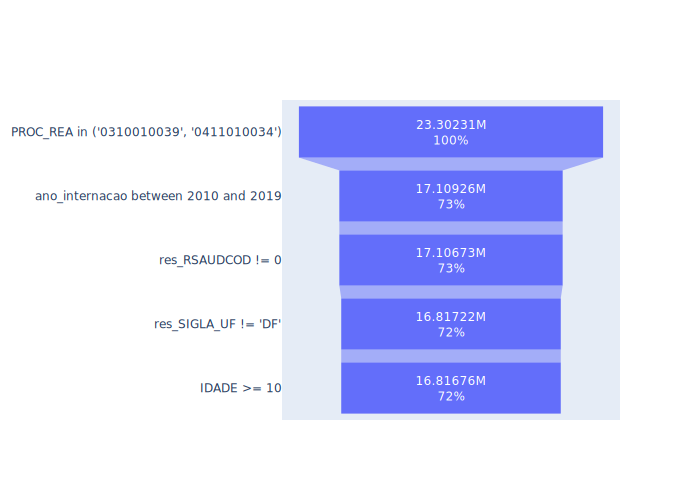

In [5]:
filters = pd.read_csv('data/consult/filters.csv')
fig_filters = go.Figure(go.Funnel(
  x = filters['Registros'],
  y = filters['Filtro'],
  textposition = "inside",
  textinfo = "value+percent initial",
))
fig_filters.show(renderer="svg")

## Criação de variáveis

Além das informações coletadas das fontes de dados, acrescentaremos algumas para facilitar o escopo de nossa análise, são elas:

### Deslocamento

Como é do nosso interesse detectar casos em que o `município` e/ou a `região de saúde` de residência diverge da de internação, criamos `1` variável de `criticidade` indicando:

- `criticidade = 0`: município de residência e internação são iguais;
- `criticidade = 1`: município de residência e internação são diferentes, mas a região de saúde de residência é igual a região de saúde de internação;
- `criticidade = 2`: tanto município e região de saúde de residência, são diferentes do município e região de saúde de internação.

### Período

Queremos comparar 2 momentos distanciados significativamente pelo tempo, que sejam recortes que sirvam como `antes` e `depois`. Para isso criamos `1` variável `momento` que informa se é:

- `antes` : 2010 e 2011;
- `depois` : 2018 e 2019;
- `durante` : demais anos intermediários.

## Tabelas geradas

Uma vez definido as informações a serem utilizadas na construção de nossa base de dados, agora vamos ver como ficou a estrutura resultante.

A base de dados resultante é um aquivo de extensão`.db` criado a partir de uma instância de um banco `SQLite3`. O arquivo contém as informações necessárias para a análise de nosso projeto, e possui `820MB` de tamanho. Ao comparar com a base completa do SIHSUS que possui `20GB`, nossa base equivale a `3.58%` do espaço da base original.

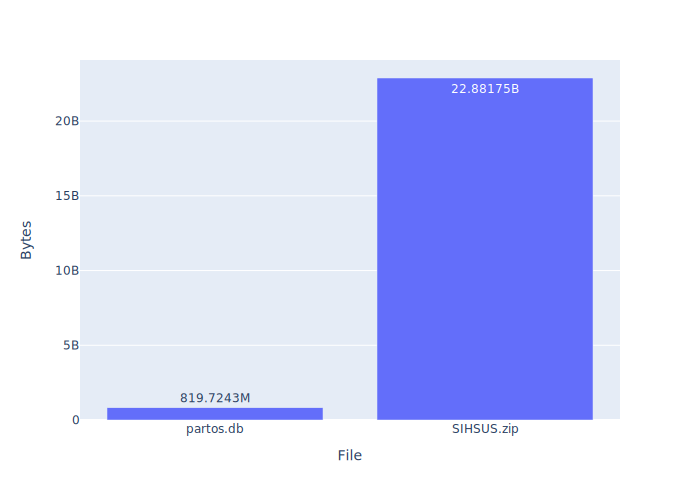

In [6]:
sizes = pd.read_csv('data/consult/sizes.csv')
fig = px.bar(
	sizes,
	x='File',
	y='Bytes',
	text_auto=True)
fig.show(renderer="svg")

Tal redução foi possível graças ao processo de filtragem, mas também devido a organização da informação em 2 tabelas, onde:

- **Tabela Partos**: possui os registros de cada ocorrência, informando as variáveis pertinentes;
- **Tabela Localidades**: possui informações relacionadas a localidade, como códigos, nomes, regiões, indicadores, etc.

Dessa forma, na tabela de partos, não é necessário ter todas as informações de localidade, ainda mais duplicado para a residência e internação, enquanto que no modelo atual, basta registrar o código do município da residência e da internação, e a partir desse código, é possível consultar na tabela de localidade informações detalhadas de tal município.

Podemos olhar alguns registros e as colunas de cada tabela abaixo:

In [7]:
cnx = sqlite3.connect(config.PATH_DB)

### Tabela Partos

A tabela de partos possui os `16816186` registros que estamos analisando.

In [8]:
pd.read_sql_query('select * from partos limit 5', cnx)

,ano,parto,cnes,idade,raca_cor,criticidade,momento,res_cod_municipio,int_cod_municipio
0,2010,NORMAL,2001020,23,Amarela,0,antes,120005,120005
1,2010,NORMAL,2000733,28,Amarela,0,antes,120040,120040
2,2010,NORMAL,2000733,38,Amarela,0,antes,120040,120040
3,2010,NORMAL,2000733,16,Amarela,0,antes,120040,120040
4,2010,NORMAL,2000733,26,Amarela,0,antes,120040,120040


### Tabela Localidades

A tabela de localidades possui `5564` municípios brasileiros que contemplam os casos visualizados na tabela de partos.

In [9]:
pd.read_sql_query('select * from places limit 5', cnx)

,cod_municipio,municipio,regiao_saude,uf,regiao,latitude,longitude,grupo
0,510452,IPIRANGA DO NORTE,5114,MT,Centro-Oeste,NaN,NaN,2
1,351600,FLORIDA PAULISTA,3514,SP,Sudeste,-21.615,-51.174,3
2,510454,ITANHANGA,5114,MT,Centro-Oeste,NaN,NaN,2
3,353990,POLONI,3522,SP,Sudeste,-20.785,-49.824,3
4,430063,AMARAL FERRADOR,4303,RS,Sul,-30.875,-52.253,3


## Conhecimento das variávies

Vamos ter um primeiro contato com algumas das variáveis ao ver a contagem que os valores de cada variável possui.

In [16]:
def query_value_counts(var, table_partos=True):
	if table_partos:
		q = f'select parto, {var} as value, count({var}) as records from partos group by parto, {var} order by count({var}) desc'
	else:
		q = f'select parto, PL.{var} as value, count(PL.{var}) as records from partos P left join places PL on P.res_cod_municipio = PL.cod_municipio group by parto, PL.{var} order by count(PL.{var}) desc'
	return q

In [17]:
def bar_plot(df, title=''):
	return px.bar(
		df,
		x='value',
		y='records',
		color = 'parto',
		category_orders={'value': df['value'].values},
		text_auto=True,
		title=title,
	)

### Conhecendo as variáveis da tabela de partos

#### Ano

Vamos começar obervando a quantidade de registros para cada ano de nossa base de dados.

**Observações**

- São todos bem parecidos

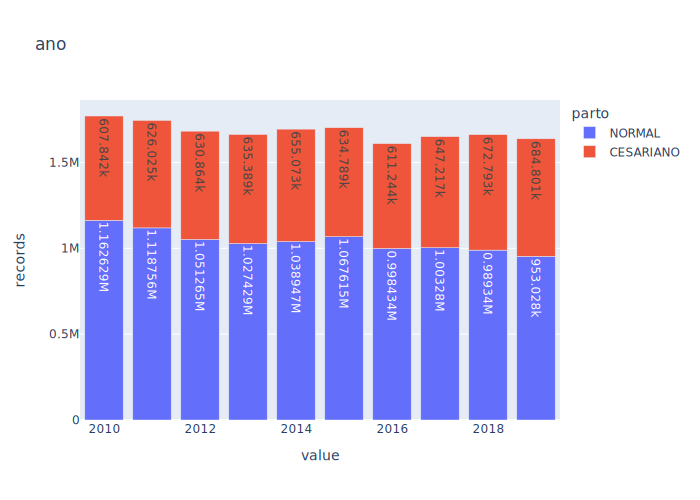

In [18]:
var = 'ano'
df = pd.read_sql_query(query_value_counts(var), cnx)
bar_plot(df, var).show(renderer="svg")

#### Parto

Em seguida vamos ver a quantidade de registros para cada tipo de parto.

**Observações**

- Cesariano é 2/3 o tamanho do Normal

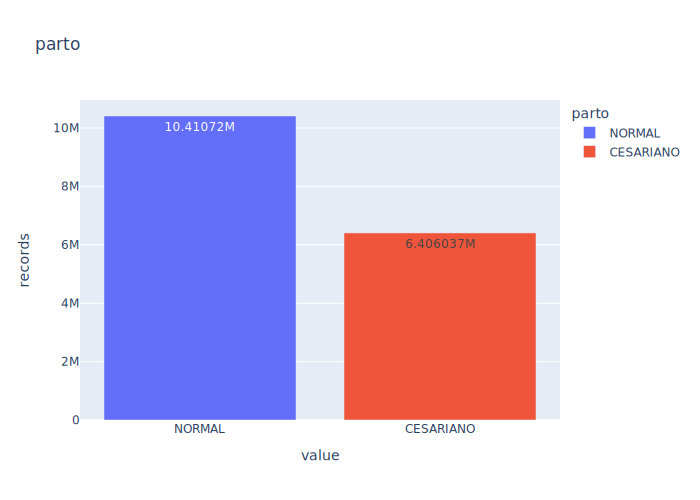

In [19]:
var = 'parto'
df = pd.read_sql_query(query_value_counts(var), cnx)
bar_plot(df, var).show(renderer="svg")

#### Idade

Idade que as gestantes costumam ter.

**Observações**

- A distribuição pode ser modelada por uma gaussiana'
- O pico é 20 anos;
- Após os 20 anos há um leve declínio.

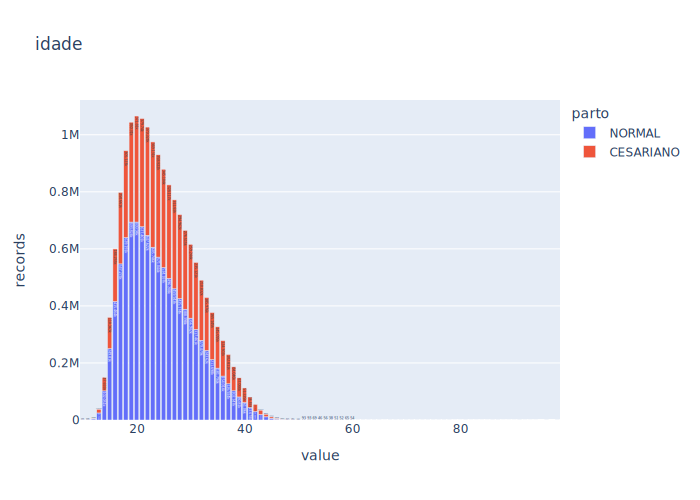

In [20]:
var = 'idade'
df = pd.read_sql_query(query_value_counts(var), cnx)
bar_plot(df, var).show(renderer="svg")

#### Raça/Cor

Vamos observar a frequência que cada raça/cor apresenta.

**Observações**

- O segundo maior valor é `None`, ou seja, não possui informação de raça/cor disponível;
- `Preta`, `Parda` e principalmente `Indígena` estão subnotificados;
- A maioria está classificada como `Amarela`;
- `Branca` é um pouco mais que a metade de `Amarela`.

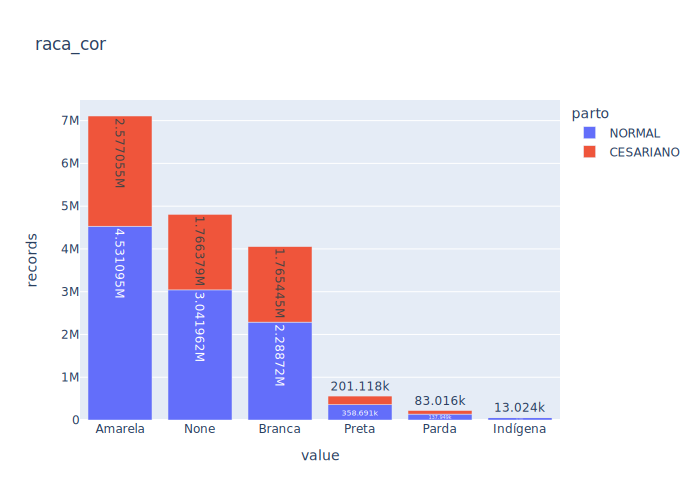

In [21]:
var = 'raca_cor'
df = pd.read_sql_query(query_value_counts(var), cnx)
bar_plot(df, var).show(renderer="svg")

#### Criticidade

A quantidade de registros que possuem o município de residência diferente do de internação (valor `1`), comparado com a quantidade cujo são iguais (valor `0`)

**Observações**

- A quantidade de municípios diferentes é cerca de 1/3 da quantidade de muncípio de residência e internação iguais.

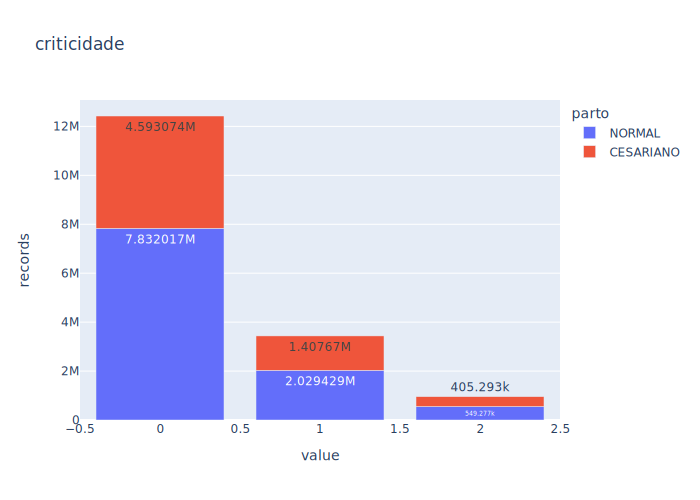

In [22]:
var = 'criticidade'
df = pd.read_sql_query(query_value_counts(var), cnx)
bar_plot(df, var).show(renderer="svg")

#### Período

Por fim, vamos comparar os 2 biênios, passado (`2010-11`) e presente (`2018-19`).

**Observações**

- O passado é um pouco maior que o presente.

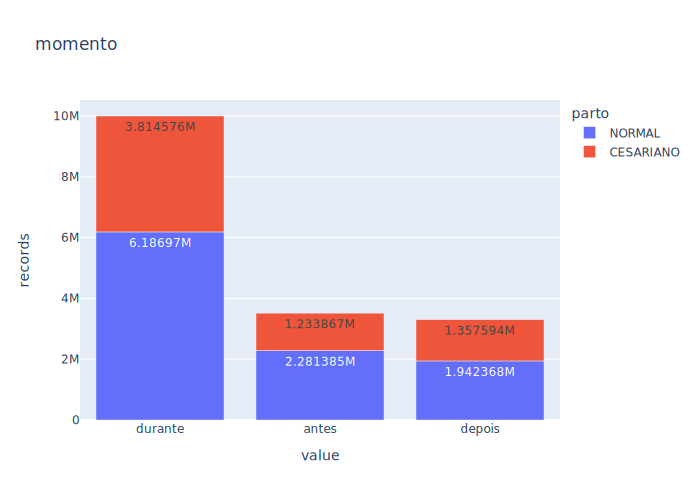

In [23]:
var = 'momento'
df = pd.read_sql_query(query_value_counts(var), cnx)
bar_plot(df, var).show(renderer="svg")

### Conhecendo as variáveis da tabela de localidades

Acima olhamos para variáveis da tabela de partos, agora olharemos para variáveis na tabela de localidades.

#### Região do Brasil

Regiões que compõe o Brasil, são elas:

- Norte
- Nordeste
- Centro-Oeste
- Sudeste
- Sul

**Observações**

- Nordeste e Sudeste são equivalentes;
- Sul e Norte também

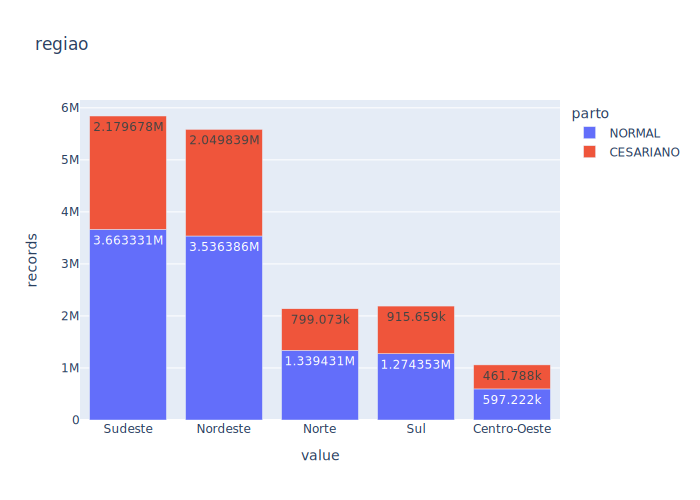

In [24]:
var = 'regiao'
df = pd.read_sql_query(query_value_counts(var, False), cnx)
bar_plot(df, var).show(renderer="svg")

#### Grupo Socioeconômico da Região de Saúde

Indicador socioeconômico que informa a qual grupo uma região de saúde pertence, sendo de 1 até 5.

**Observações**

- Há alguns registros que não foi possível obter seu respectivo indicador socioeconômico, ficando no grupo `0`

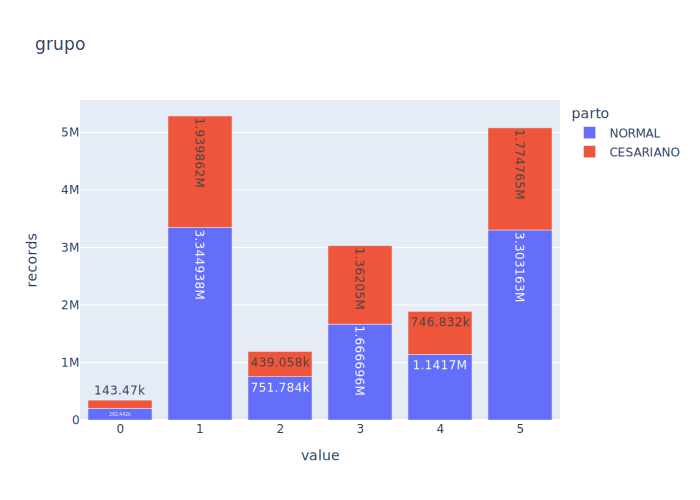

In [25]:
var = 'grupo'
df = pd.read_sql_query(query_value_counts(var, False), cnx)
bar_plot(df, var).show(renderer="svg")

#### Unidade Federativa (UF)

O Brasil constitui de 26 Estados.

**Observações**

- `SP` é quase o dobro do segundo estado `MG`

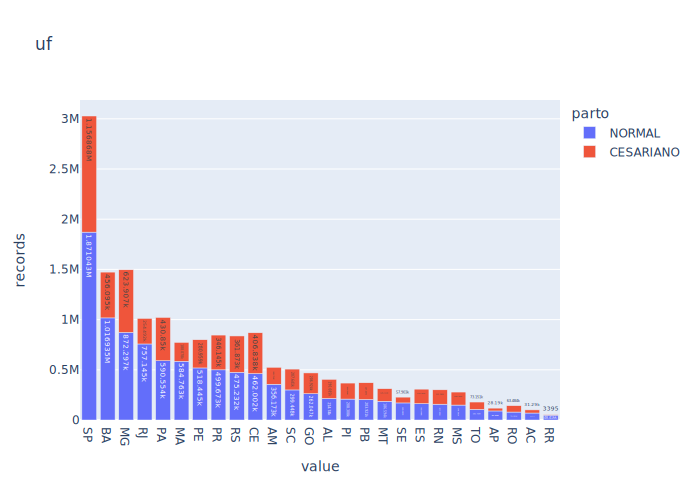

In [26]:
var = 'uf'
df = pd.read_sql_query(query_value_counts(var, False), cnx)
bar_plot(df, var).show(renderer="svg")

# Investigações

Agora que já tivemos um primeiro contato com nossa base de dados, vamos começar a investigar as informações presentes.

In [27]:
path_year_percent = 'queries/info/check.sql'
with open(path_year_percent) as f:
	query = f.read()
df = pd.read_sql_query(query, cnx)
df

DatabaseError: Execution failed on sql 'select
	IDADE,
	count(IDADE) as records
from
	"datasus-sih"
	-- partos
where -- 157033546
	PROC_REA in ('0310010039', '0411010034') -- 23302307
	and
	ano_internacao between 2010 and 2019 -- 17109256
	and
	res_RSAUDCOD != 0 -- 17106725
	and
	res_SIGLA_UF != 'DF' -- 16817215
	and
	IDADE <= 18
group by
	IDADE
order by
	IDADE asc
-- select
-- 	count(*) as records
-- from
-- 	partos
-- where
-- 	not (mov_municipio = 0 and mov_regiao_saude = 1)': no such table: datasus-sih

## Períodos

## Tendência

In [ ]:
path_year_percent = 'queries/info/year_percent.sql'
with open(path_year_percent) as f:
	q_year_percent = f.read()

In [ ]:
def plot_year_percent(df):
	return sns.lineplot(
		x='ano',
		y='percent',
		hue='parto',
		style='scope',
		data=df
	)

In [ ]:
def run_q(place=None, value=None):
	if place and value:
		q = q_year_percent.replace(
			'uf is not null',
			f'{place} = "{value}"'
		)
	else:
		q = q_year_percent
	df = pd.read_sql_query(q, cnx)
	return df

In [ ]:
df = run_q()
plot_year_percent(df)

In [ ]:
df = run_q(place='uf', value='RJ')
plot_year_percent(df)

In [ ]:
df = run_q(place='regiao', value='Norte')
plot_year_percent(df)

In [ ]:
df = run_q(place='grupo', value='1')
plot_year_percent(df)

In [ ]:
fig = px.line(df, x='ano', y='percent', color='parto', symbol="scope")
fig.show()

## Trend over Years (Scatter Plot)

## Biênios Past and Present (Bar Plot)